In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using MacroTools
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [2]:
@model [ default_factorisation = MeanField() ] function transition_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

transition_model (generic function with 1 method)

In [3]:
function inference(data, criterion)
    n = length(data)
    
    model, (s, x, A, B) = transition_model(n, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    update!(x, data)
    repeat!(model, criterion)
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    unsubscribe!(fesub)
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference (generic function with 1 method)

In [4]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [5]:
x_data, s_data = generate_data(100);

In [11]:
@time sbuffer, Abuffer, Bbuffer, fe = inference(x_data, 20);

┌ Error: Failed to revise /Users/bvdmitri/.julia/dev/ReactiveMP/src/marginal.jl
│   exception = (LoadError("/Users/bvdmitri/.julia/dev/ReactiveMP/src/marginal.jl", 66, "unexpected \"=\""), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000014923e5ae])
└ @ Revise /Users/bvdmitri/.julia/packages/Revise/VxkZO/src/packagedef.jl:709


LoadError: [91mMethodError: no method matching update!(::DataVariable{PointMass{Array{Float64,1}},Rocket.RecentSubjectInstance{Union{Message{Missing}, Message{PointMass{Array{Float64,1}}}},Subject{Union{Message{Missing}, Message{PointMass{Array{Float64,1}}}},AsapScheduler,AsapScheduler}}}, ::PointMass{Array{Float64,1}})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  update!(::DataVariable, [91m::Real[39m) at /Users/bvdmitri/.julia/dev/ReactiveMP/src/variables/data.jl:43[39m
[91m[0m  update!(::DataVariable, [91m::AbstractArray{T,1} where T[39m) at /Users/bvdmitri/.julia/dev/ReactiveMP/src/variables/data.jl:44[39m
[91m[0m  update!(::DataVariable, [91m::AbstractArray{T,2} where T[39m) at /Users/bvdmitri/.julia/dev/ReactiveMP/src/variables/data.jl:45[39m

In [7]:
mean(Abuffer[end])

LoadError: [91mUndefVarError: Abuffer not defined[39m

In [8]:
mean(Bbuffer[end])

LoadError: [91mUndefVarError: Bbuffer not defined[39m

In [9]:
using Plots

In [10]:
p1 = scatter(argmax.(s_data))
p2 = scatter(argmax.(ReactiveMP.probvec.(sbuffer[end])))
p3 = plot(fe)

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

┌ Error: Failed to revise /Users/bvdmitri/.julia/dev/ReactiveMP/src/marginal.jl
│   exception = (LoadError("/Users/bvdmitri/.julia/dev/ReactiveMP/src/marginal.jl", 66, "unexpected \"=\""), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000014923e5ae])
└ @ Revise /Users/bvdmitri/.julia/packages/Revise/VxkZO/src/packagedef.jl:709
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/bvdmitri/.julia/dev/ReactiveMP/src/marginal.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /Users/bvdmitri/.julia/packages/Revise/VxkZO/src/packagedef.jl:805


LoadError: [91mUndefVarError: sbuffer not defined[39m

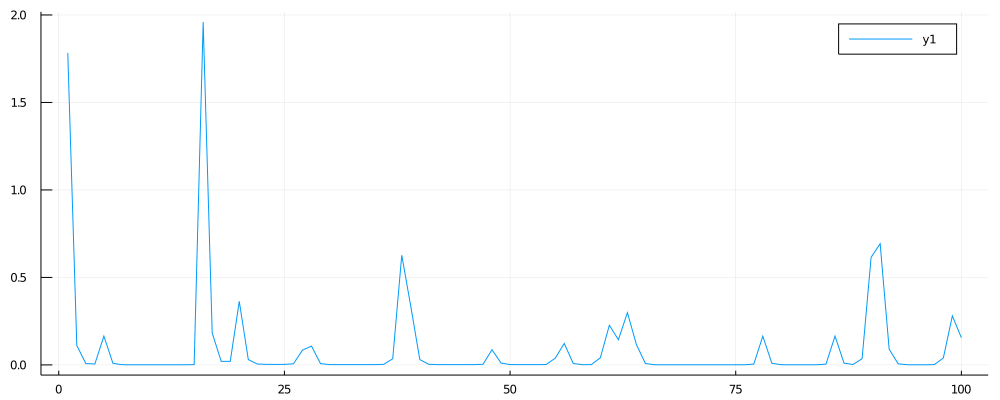

In [11]:
plot(sum.(map(a -> abs.(a), ReactiveMP.probvec.(sbuffer[end]) .- s_data)), size = (1000, 400))